In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

import sys
sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [2]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots/20231019_1_IP_GFPCAAX-CheHis_uu_0p5/'

In [3]:
dat_files

['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5\\20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_fr001\\2024-04-30_11-01-12\\Data\\20231019_1_fr001_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5\\20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_fr006\\2024-04-30_11-02-37\\Data\\20231019_1_fr006_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5\\20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_fr011\\2024-04-30_11-03-53\\Data\\20231019_1_fr011_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20231019_1_IP_GFPCAAX-CheHis_uu_0p5\\20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_fr016\\2024-04-30_11-05-08\\Data\\20231019_1_fr016_cell_data_

In [4]:
micron_size=553.57
pixel_size=1024

In [5]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_edges.csv', skiprows=[1,2,3])



cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)


    scale_factor=1.03

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    # plt.scatter(cc[:,0], cc[:,1])
    # plt.scatter(tm_cc[:,0], tm_cc[:,1])
    # plt.title(str(i))
    # plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in tm_track_dat[tm_track_dat.NUMBER_SPLITS>0].TRACK_ID:

    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)
dat_df.to_csv(save_folder+"/20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv",index=False)

In [8]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [9]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

#no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(dat_files))[0])]

div_cells=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time<len(dat_files))[0])]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [53]:
cell_dat=dat_df.groupby('cell_id_new').min().time.to_frame()
dat_mi=dat_df.set_index(['cell_id_new','time'])
dat_mi['dx0']=dat_mi.cc_x-dat_df.groupby('cell_id_new').first().cc_x
dat_mi['dy0']=dat_mi.cc_y-dat_df.groupby('cell_id_new').first().cc_y
dat_mi['ds0']=np.sqrt(dat_mi.dx0**2 +dat_mi.dy0**2)
dat_mi['ds0_sq']=dat_mi.dx0**2 +dat_mi.dy0**2
cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_29624\3339878596.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_29624\4028117221.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


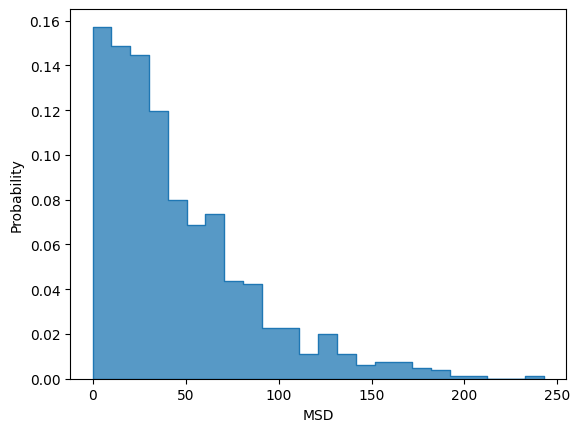

In [54]:
fig, ax=plt.subplots()
g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


plt.savefig(plot_dir+'/MSD.png', dpi=300, bbox_inches='tight')

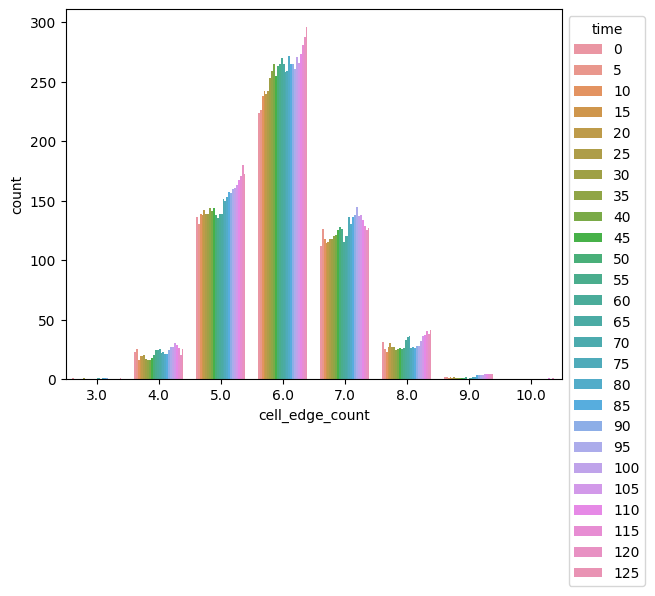

In [68]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

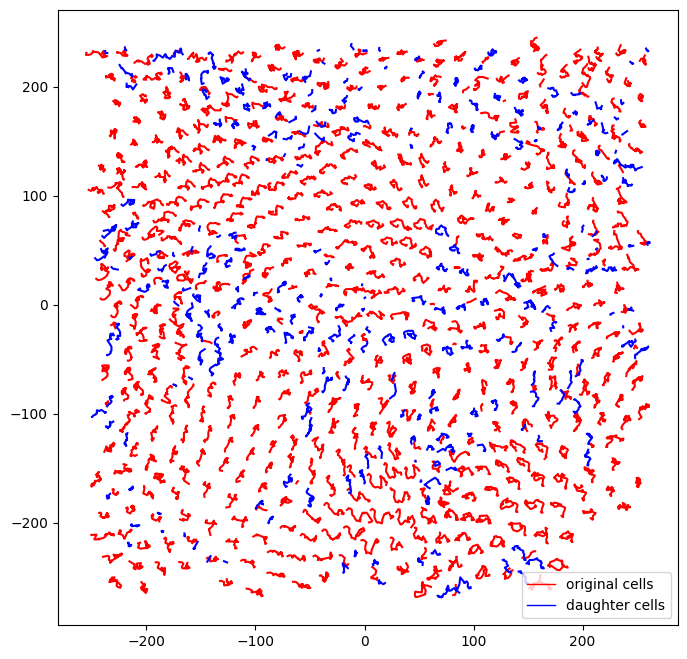

In [71]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

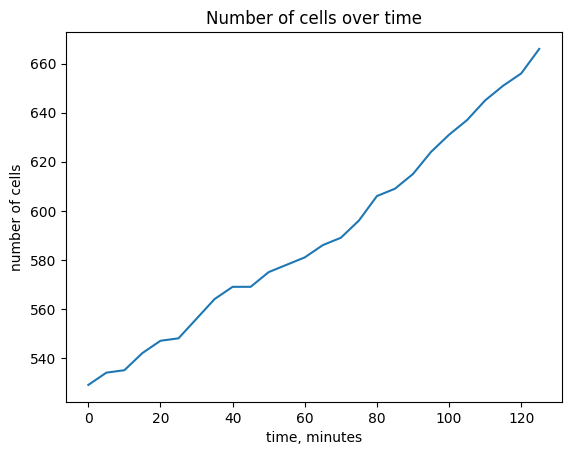

In [57]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
#plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

In [11]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
0,324.0,81.965066,461.914325,3.813714,0.523466,6.0,0.370888,61.833026,197.153724,0,3373,0,0,NaN,0,0.370888,1.000000,1.000000,1.000000
1,71.0,90.191822,531.896907,3.910690,0.630955,5.0,1.156701,-254.033641,-133.279609,1,5851,0,0,NaN,0,1.156701,1.000000,1.000000,1.000000
2,491.0,103.957289,752.825184,3.788854,0.603623,7.0,0.703593,208.309216,416.606105,2,2137,0,0,NaN,0,0.703593,1.000000,1.000000,1.000000
3,323.0,77.607203,417.406573,3.798590,0.790287,6.0,0.152688,-370.833641,195.653724,3,3388,0,0,NaN,0,0.152688,1.000000,1.000000,1.000000
4,307.0,87.883193,529.847208,3.817952,0.563188,6.0,0.185529,344.999692,149.320391,4,3538,0,0,NaN,0,0.185529,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15333,7.0,54.086782,174.224420,4.097667,0.529660,4.0,1.008414,345.295842,-141.663082,797,17657,125,25,499.0,1,1.008414,0.798658,0.945105,0.815114
15334,86.0,56.999536,205.262720,3.978472,0.661295,5.0,0.901263,46.395842,-128.013082,798,17644,125,25,512.0,1,0.901263,1.504292,1.158036,1.681831
15335,302.0,59.831916,237.033056,3.886230,0.384019,6.0,1.675264,43.295842,-159.079749,799,17668,125,25,512.0,1,1.466329,1.263856,1.017958,0.492881
15336,488.0,73.980602,372.166787,3.834856,0.697678,6.0,1.409486,-440.037492,430.253585,800,17210,125,25,513.0,1,1.409486,1.125775,1.071800,0.949892


In [58]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t125=no_div[no_div.tm_frame==25][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]


cc_nd=pd.merge(nd_t0, nd_t125, on='cell_id_new', suffixes=("_0", "_125"))
cc_nd['cc_dx']=cc_nd.cc_x_125-cc_nd.cc_x_0
cc_nd['cc_dy']=cc_nd.cc_y_125-cc_nd.cc_y_0

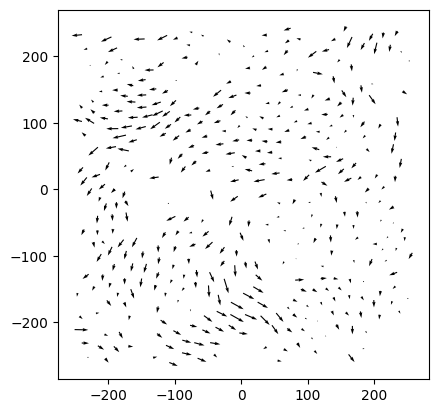

In [59]:
dx= cc_nd.cc_dx
dy=cc_nd.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)






#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
#plt.xlim(-200,200)
#plt.ylim(-350,350)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_displacement.png', dpi=300, bbox_inches='tight')

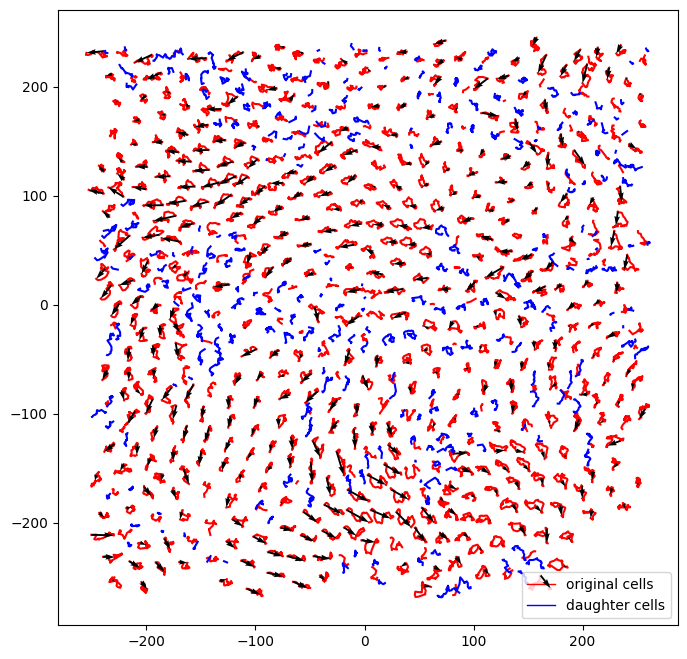

In [70]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

plt.savefig(plot_dir+'/cell_tracks_overlay.png', dpi=300, bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

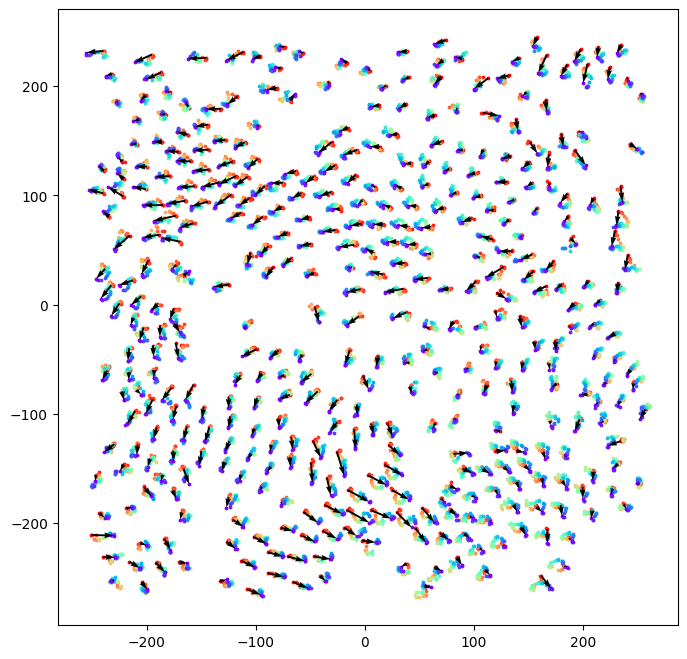

In [60]:
fig,ax=plt.subplots(figsize=(8, 8))

n=len(dat_files)

colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))


for i in range(n):
    c = next(colour)
    ax.scatter(no_div[no_div.tm_frame==i].cc_x, no_div[no_div.tm_frame==i].cc_y, c=c, label='original cells', s=3)

plt.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

ax.set_aspect('equal')

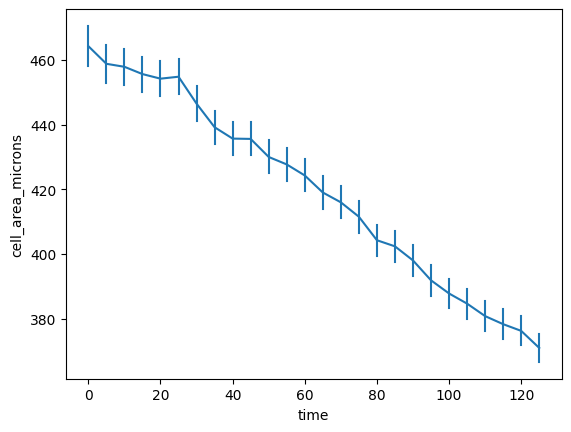

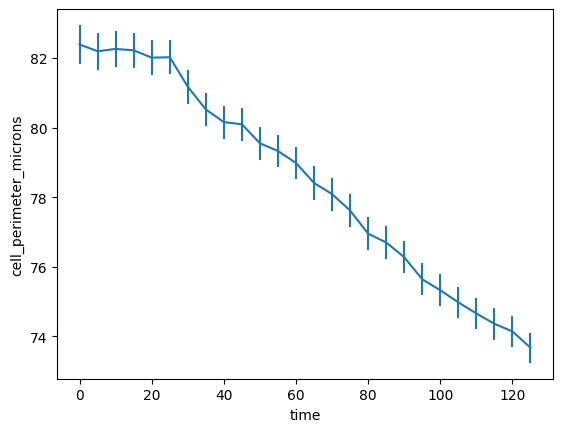

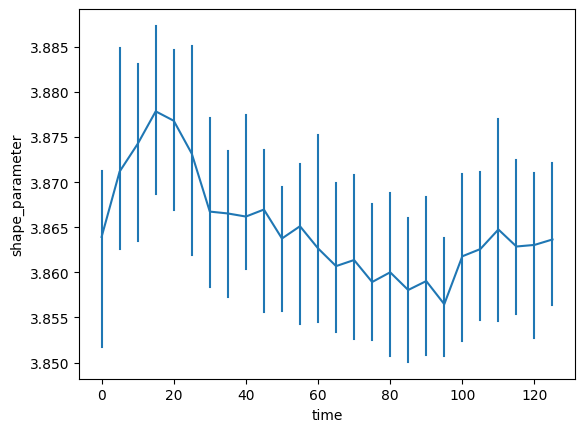

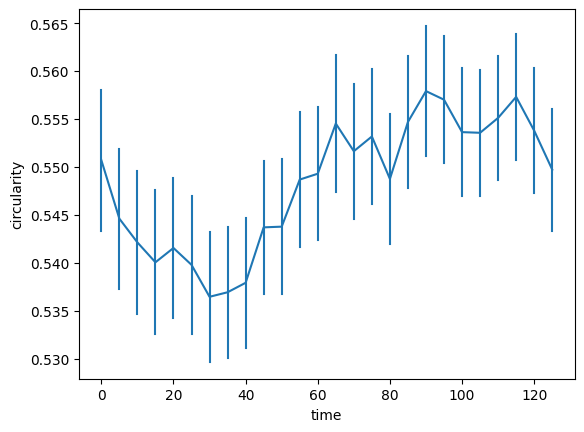

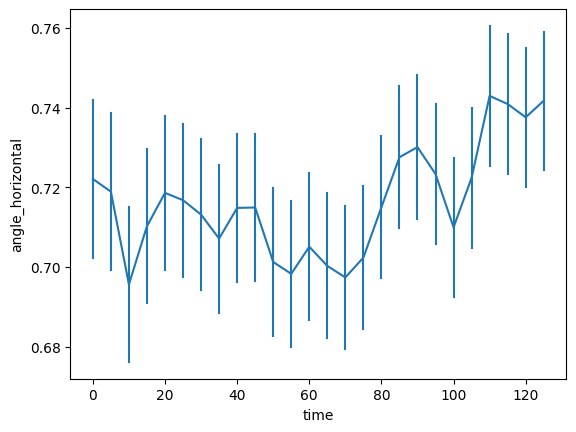

In [61]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

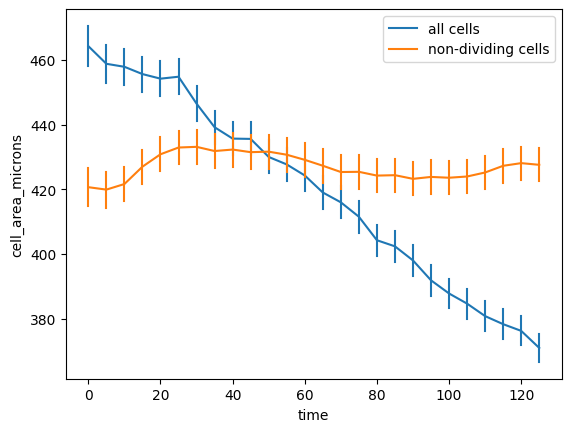

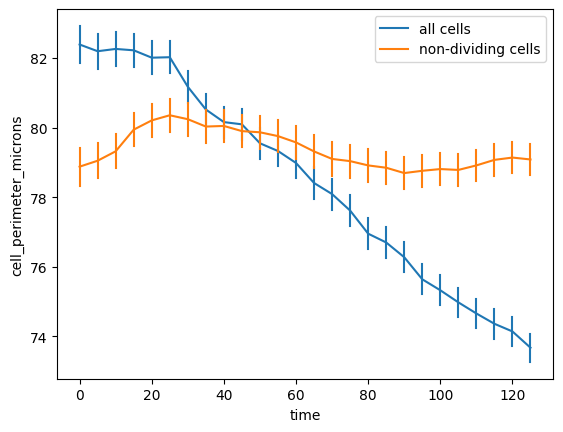

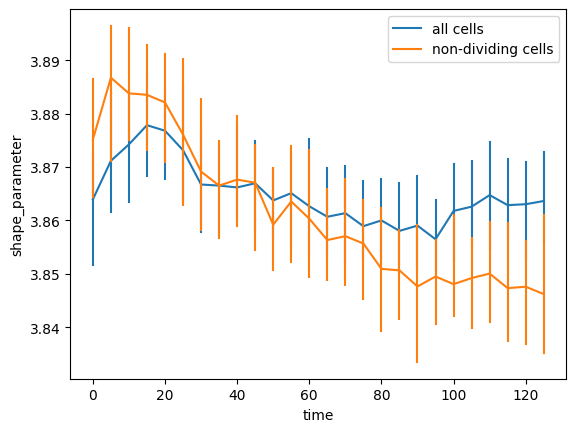

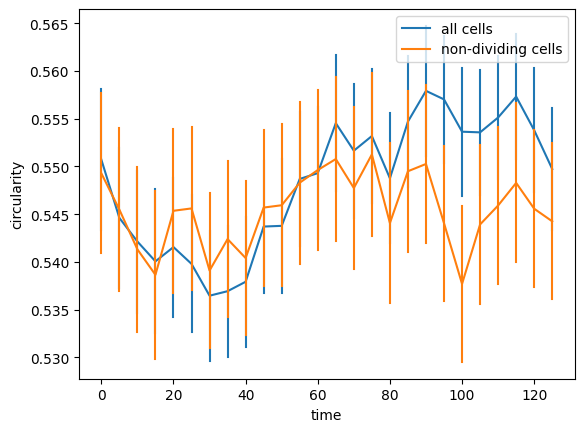

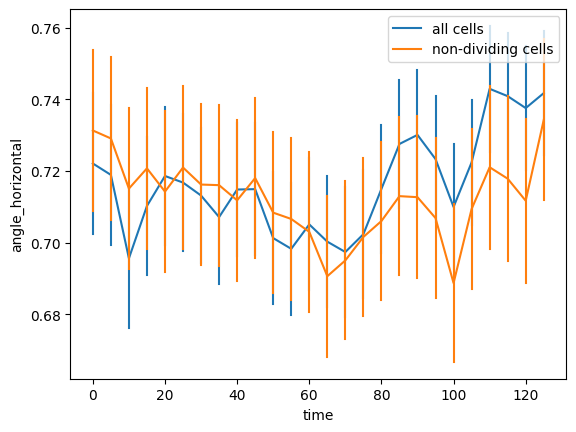

In [62]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

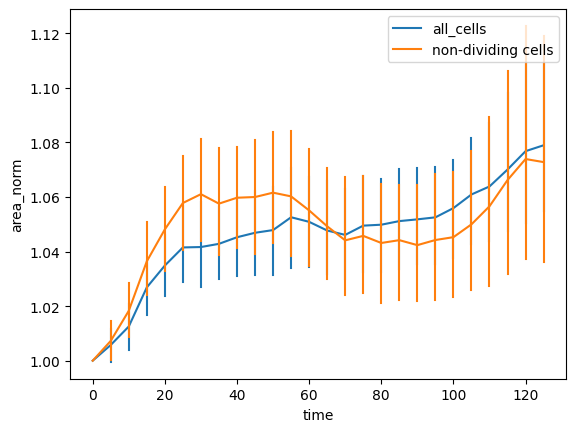

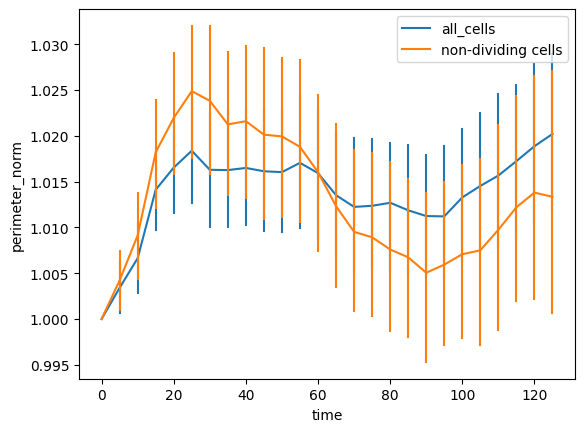

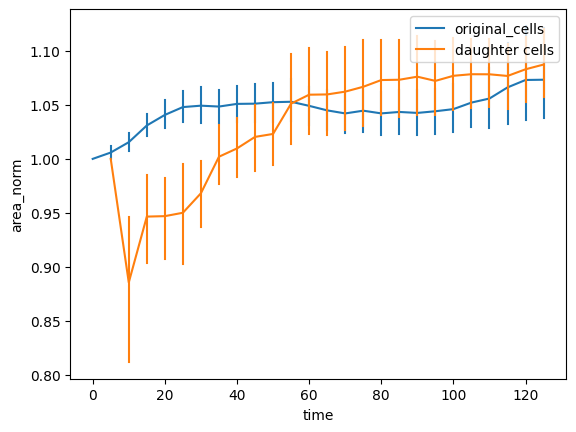

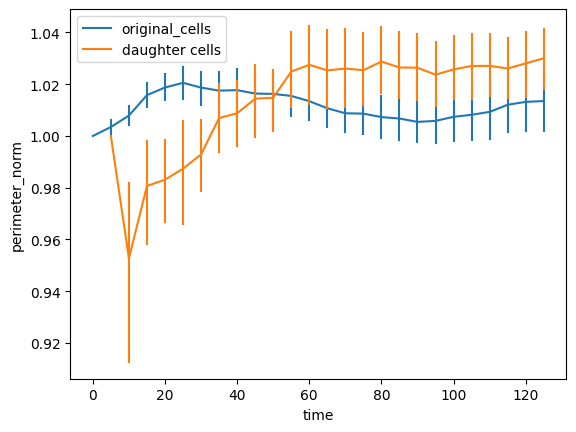

In [10]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars', label='all_cells')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars', label='non-dividing cells')

plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars', label='all_cells')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars', label='non-dividing cells')

plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()


sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars', label='original_cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='time',err_style='bars', label='daughter cells')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', label='original_cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='time',err_style='bars', label='daughter cells')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d.png', dpi=300, bbox_inches='tight')
plt.show()


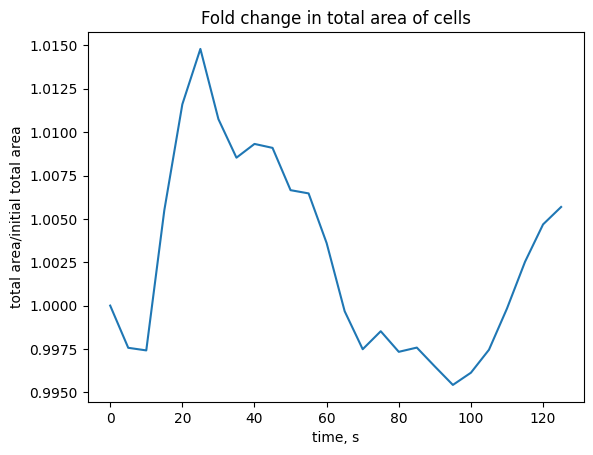

In [64]:
t=np.linspace(0, 125, 26)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
#plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

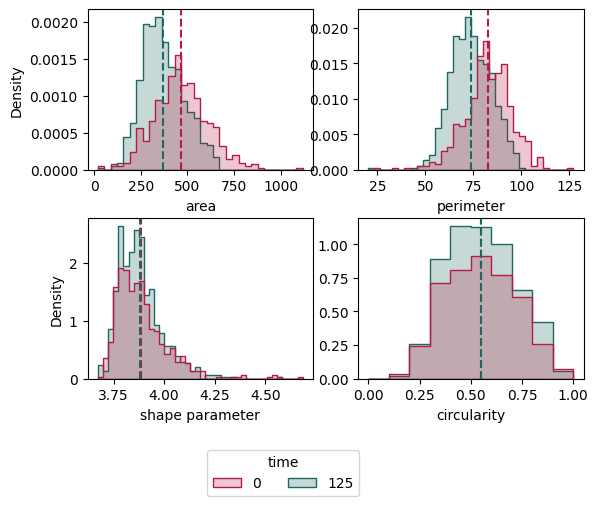

In [65]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==125)], hue='time',x='cell_area_microns', stat='density',element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==125].cell_area_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==125)], hue='time',x='cell_perimeter_microns', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==125].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==125)], hue='time',x='circularity', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==125].circularity), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) |(dat_df.time==125)], hue='time',x='shape_parameter', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==125].shape_parameter), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

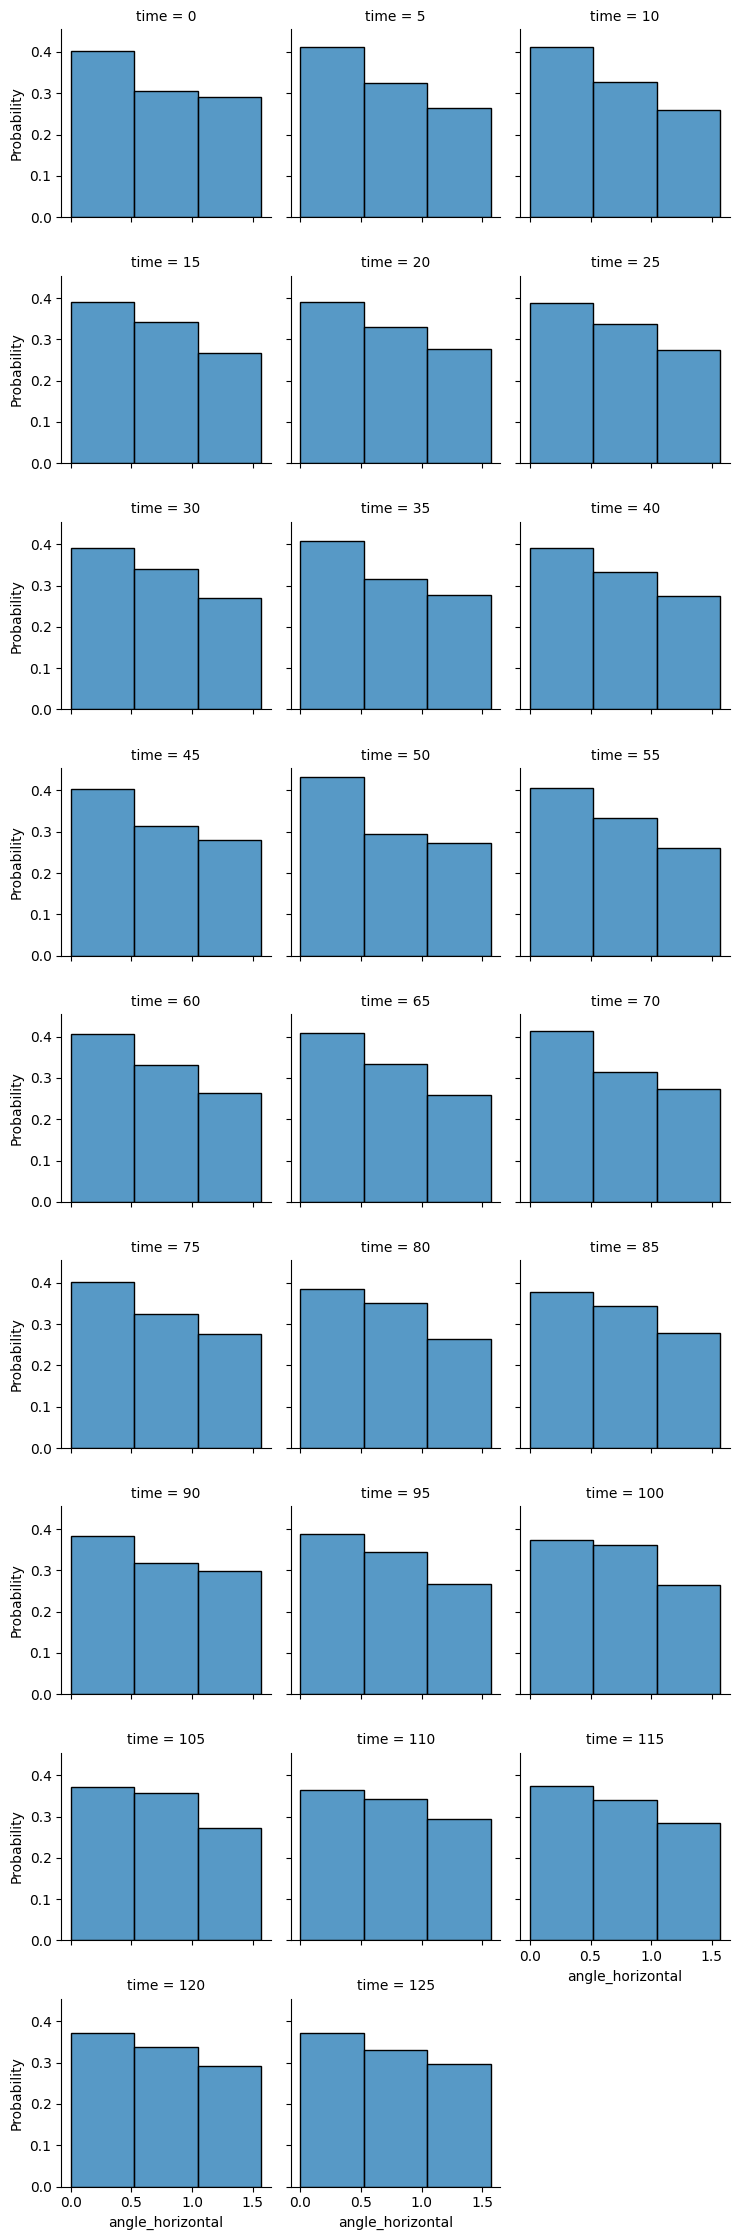

In [66]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

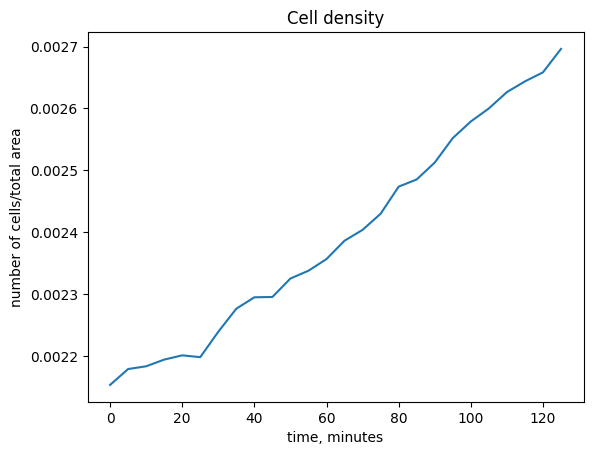

In [67]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

In [29]:
dat_mi.first()

TypeError: NDFrame.first() missing 1 required positional argument: 'offset'

In [41]:
cell_dat['initial_area']=dat_df.groupby('cell_id_new').first().cell_area_microns
cell_dat['initial_cc_x']=dat_df.groupby('cell_id_new').first().cc_x
cell_dat['initial_cc_y']=dat_df.groupby('cell_id_new').first().cc_y

cell_dat['parent_id']=dat_df.groupby('cell_id_new').first().parent_id
cell_dat['number_divisions']=dat_df.groupby('cell_id_new').last().divisions
cell_dat['displacement']=dat_mi.groupby('cell_id_new').last().ds0


In [40]:
dat_mi.groupby('cell_id_new').last().ds0

cell_id_new
0      12.898040
1      23.429212
2       9.647258
3      22.849757
4      10.579895
         ...    
797    27.675461
798    12.754659
799    25.223038
800     5.098574
801     4.771334
Name: ds0, Length: 801, dtype: float64

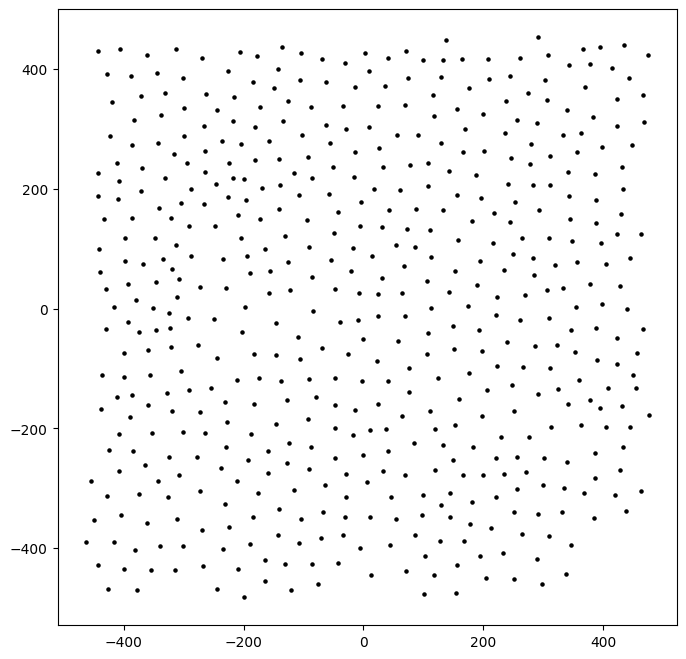

In [45]:
fig,ax=plt.subplots(figsize=(8, 8))
plt.scatter(dat_df[dat_df.time==0].cc_x, dat_df[dat_df.time==0].cc_y, s=5, c='k')
ax.set_aspect('equal')

In [11]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_21488\2948227597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')


In [12]:
daughter_cells

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm,aligned_time
1053,97.0,73.420926,324.682767,4.074649,0.357711,5.0,2.260121,141.951247,19.184081,660,4653,5,1,262.0,1,0.881471,1.000000,1.000000,1.000000,0
1054,271.0,72.288522,332.573347,3.963927,0.435473,6.0,3.090899,146.708489,1.722840,661,4797,5,1,262.0,1,0.050694,1.000000,1.000000,1.000000,0
1055,8.0,73.989944,328.335813,4.083321,0.443349,4.0,2.579806,-95.748684,-3.818266,704,4805,5,1,336.0,1,0.561787,1.000000,1.000000,1.000000,0
1056,273.0,77.387308,388.099653,3.928241,0.496495,6.0,0.777838,-111.065562,4.876315,705,4766,5,1,336.0,1,0.777838,1.000000,1.000000,1.000000,0
1057,436.0,78.253016,400.227767,3.911537,0.428600,7.0,1.642787,-158.341944,1.143630,708,4771,5,1,340.0,1,1.498805,1.000000,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15333,7.0,54.034072,173.885010,4.097667,0.529660,4.0,1.008414,186.665448,-76.582453,797,17657,125,25,499.0,1,1.008414,0.798658,0.945105,0.815114,55
15334,86.0,56.943988,204.862844,3.978472,0.661295,5.0,0.901263,25.081393,-69.203322,798,17644,125,25,512.0,1,0.901263,1.504292,1.158036,1.681831,30
15335,302.0,59.773608,236.571287,3.886230,0.384019,6.0,1.675264,23.405546,-85.997829,799,17668,125,25,512.0,1,1.466329,1.263856,1.017958,0.492881,30
15336,488.0,73.908505,371.441761,3.834856,0.697678,6.0,1.409486,-237.882377,232.593239,800,17210,125,25,513.0,1,1.409486,1.125775,1.071800,0.949892,10


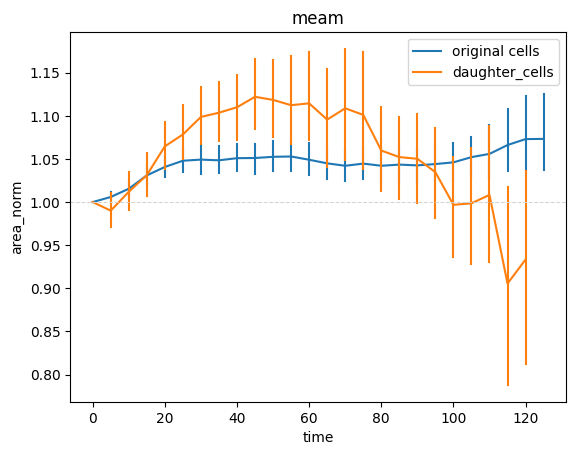

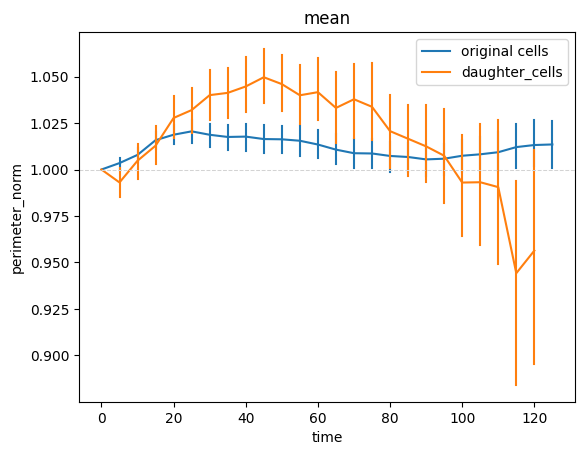

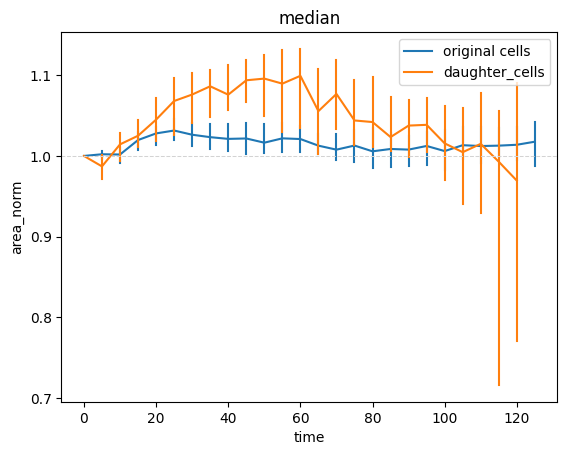

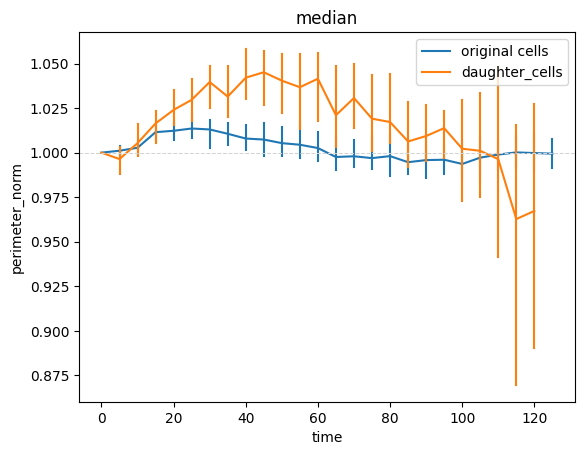

In [20]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('meam')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', estimator='median',label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars',estimator='median', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

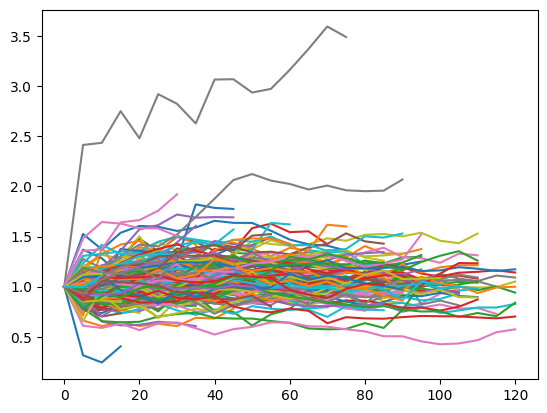

In [30]:
for i in np.unique(daughter_cells.cell_id_new):
    plt.plot(daughter_cells[daughter_cells.cell_id_new==i].aligned_time,daughter_cells[daughter_cells.cell_id_new==i].area_norm)

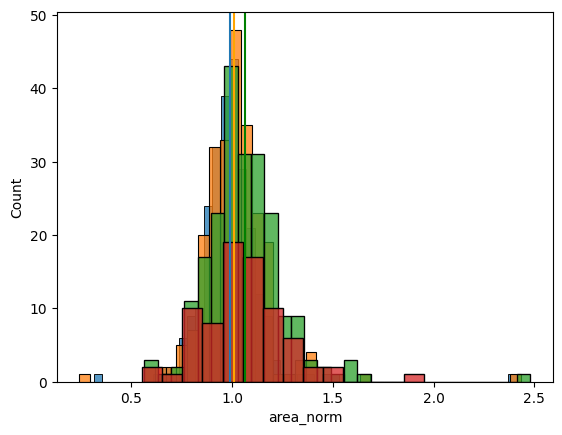

In [14]:
fig, ax=plt.subplots()
sns.histplot(data=daughter_cells[daughter_cells.aligned_time==5], x='area_norm', ax=ax)
sns.histplot(data=daughter_cells[daughter_cells.aligned_time==10], x='area_norm', ax=ax)
sns.histplot(data=daughter_cells[daughter_cells.aligned_time==20], x='area_norm', ax=ax)
sns.histplot(data=daughter_cells[daughter_cells.aligned_time==80], x='area_norm', ax=ax)

ax.axvline(daughter_cells[daughter_cells.aligned_time==5].area_norm.mean())
ax.axvline(daughter_cells[daughter_cells.aligned_time==10].area_norm.mean(), c='orange')
ax.axvline(daughter_cells[daughter_cells.aligned_time==20].area_norm.mean(), c='green')

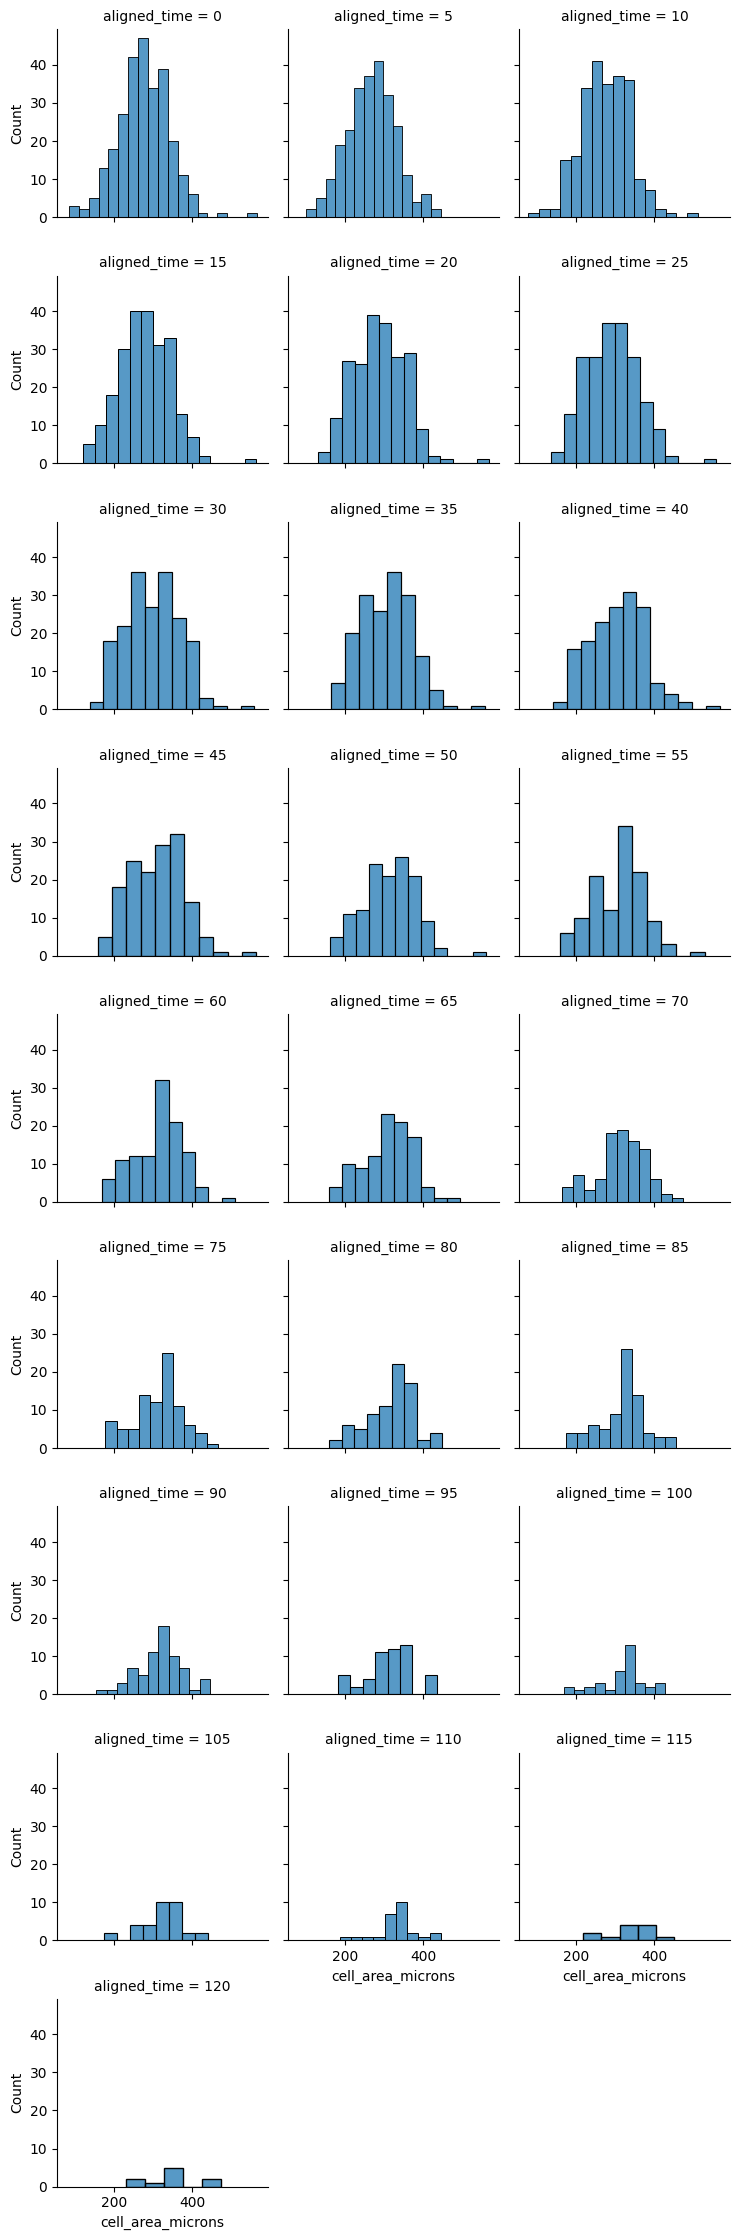

In [19]:
g = sns.FacetGrid(daughter_cells, col="aligned_time", height=2.5, col_wrap=3)
g.map(sns.histplot, "cell_area_microns")

In [17]:
daughter_cells.groupby('').count()

,cell_id_old,cell_perimeter_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm,aligned_time
cell_area_microns,,,,,,,,,,,,,,,,,,,
77.298462,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
83.289459,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
98.486132,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
100.239594,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
105.207737,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564.907100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
565.199343,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
566.222196,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [1]:
dat_df

NameError: name 'dat_df' is not defined